# Keep top 100 CBSAs

In [2]:
import pandas as pd
import datetime
import psycopg2
import numpy as np
import os
import seaborn as sns
pd.set_option("display.max_columns",999)

import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:.2f}'.format
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

conn = psycopg2.connect(
    host = 'lease-data.cnzawwknyviz.us-east-1.rds.amazonaws.com',
    port = 5432,
    user = 'costar',
    password = 'Costar12',
    database='costar'
    )
cursor = conn.cursor() 



###  Read the merged lease data in AWS

In [3]:
data = pd.read_sql(
'''
SELECT *
FROM lease_clean_oct2
''', con = conn)

###  Create a dataframe

In [4]:
lease = pd.DataFrame(data)

lease.head(1)

,leasedeal_id,property_id,renewal,sqft_min,sqft_max,date_on_market,date_off_market,days_on_market,actual_vacancy,from_date,to_date_,lease_sign_date,lease_expiration_date,lease_term_in_months,rate_actual,estimated_rent,service_type_id,property_type_id,location_occupancy_id,rba,tenant_improvement_allowance_per_sqft,free_months,construction_year,building_rating_id,research_market_name,cbsaid,cbsa_cities,cbsa_states,submarket_name,zip,currently_occupied_fl,year_on_market,year_off_market,delete_rec,new_from_date,new_to_date,year_from,year_to,years_occupied,actual_estimated_rent
0,110498312.00,157648,NaN,3650.00,3650.00,2006-03-31,2006-12-31,275.00,1.00,2006-10-05,2014-04-29,2006-09-05,2011-10-05,60.00,NaN,39.20,4.00,5.00,111764312.00,3650.00,NaN,NaN,1928.00,3.00,New York City,35614.00,New York-Jersey City-White Plains,NY-NJ,Murray Hill,10016.00,N,2006,2006,N,2006-10-05,2014-04-29,2006,2014,8,NaN


###  Get a count of Property IDs for each CBSA

In [5]:
cbsa_groups = lease.groupby('cbsaid')['property_id'].count().reset_index()

cbsa_groups.rename(columns = {cbsa_groups.columns[1]: 'property_count' }, inplace = True)

top_100 = cbsa_groups.sort_values(by = ['property_count'], ascending = False).head(100)

###  Merge the counts into the existing lease dataframe

In [8]:
lease2 = pd.merge(lease, top_100, on = 'cbsaid', how = 'left')

# comparing row counts, i get the same count for raw and merged:
lease2[lease2['cbsaid'] == 39580.00] #7781 x 40 + 1 for property count

#lease[lease['cbsaid'] == 39580.00] #7781 x 40

,leasedeal_id,property_id,renewal,sqft_min,sqft_max,date_on_market,date_off_market,days_on_market,actual_vacancy,from_date,to_date_,lease_sign_date,lease_expiration_date,lease_term_in_months,rate_actual,estimated_rent,service_type_id,property_type_id,location_occupancy_id,rba,tenant_improvement_allowance_per_sqft,free_months,construction_year,building_rating_id,research_market_name,cbsaid,cbsa_cities,cbsa_states,submarket_name,zip,currently_occupied_fl,year_on_market,year_off_market,delete_rec,new_from_date,new_to_date,year_from,year_to,years_occupied,actual_estimated_rent,property_count
37,10812658.00,68380,NaN,NaN,NaN,None,None,NaN,NaN,1998-06-15,2005-10-31,1998-05-16,2005-12-31,90.00,NaN,NaN,NaN,5.00,10812658.00,2752.00,NaN,NaN,1997.00,3.00,Raleigh/Durham,39580.00,Raleigh,NC,Route 1,27604.00,N,None,None,N,1998-06-15,2005-10-31,1998,2005,7,NaN,7781.00
82,114154170.00,67719,NaN,2987.00,2987.00,2010-03-31,2013-09-30,1279.00,1.00,2014-02-12,2015-02-23,2013-07-11,2014-07-10,12.00,NaN,23.79,7.00,5.00,123021054.00,2987.00,NaN,NaN,1973.00,3.00,Raleigh/Durham,39580.00,Raleigh,NC,Glenwood/Creedmoor,27612.00,N,2010,2013,N,2014-02-12,2015-02-23,2014,2015,1,NaN,7781.00
202,112621810.00,652738,NaN,NaN,NaN,None,None,NaN,NaN,2011-11-01,2016-07-05,2011-10-01,2014-10-31,36.00,15.00,12.83,7.00,5.00,119943997.00,2000.00,NaN,NaN,1999.00,2.00,Raleigh/Durham,39580.00,Raleigh,NC,Glenwood/Creedmoor,27609.00,N,None,None,N,2011-11-01,2016-07-05,2011,2016,5,1.17,7781.00
228,115916611.00,1299537,NaN,1485.00,1485.00,2012-06-30,2015-03-31,1004.00,1.00,2015-01-01,2015-09-25,2014-12-02,2017-12-31,36.00,NaN,27.19,7.00,5.00,125970951.00,1485.00,NaN,NaN,2003.00,4.00,Raleigh/Durham,39580.00,Raleigh,NC,Johnston County,27520.00,N,2012,2015,N,2015-01-01,2015-09-25,2015,2015,0,NaN,7781.00
239,30017502.00,67635,NaN,NaN,NaN,None,None,NaN,NaN,1978-01-15,1999-10-14,1977-12-16,1999-10-14,261.00,NaN,NaN,11.00,5.00,30017502.00,NaN,NaN,NaN,1967.00,2.00,None,39580.00,Raleigh,NC,Raleigh,NaN,N,None,None,N,1978-01-15,1999-10-14,1978,1999,21,NaN,7781.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1066287,111283119.00,5374899,NaN,1200.00,1200.00,2008-03-31,2008-12-31,275.00,1.00,2008-10-17,None,2008-09-17,2010-10-17,24.00,NaN,20.57,13.00,5.00,113923585.00,1200.00,NaN,NaN,2007.00,3.00,Raleigh/Durham,39580.00,Raleigh,NC,6 Forks Falls of Neuse,27615.00,Y,2008,2008,N,2008-10-17,2021-12-31,2008,2021,13,NaN,7781.00
1066566,50001451.00,67525,NaN,NaN,NaN,None,None,NaN,NaN,1989-01-15,1997-09-14,1988-12-16,1997-09-14,104.00,NaN,NaN,11.00,5.00,50001451.00,NaN,NaN,NaN,1989.00,4.00,Raleigh/Durham,39580.00,Raleigh,NC,West Raleigh,27607.00,N,None,None,N,1989-01-15,1997-09-14,1989,1997,8,NaN,7781.00
1066629,115465261.00,7060765,NaN,1000.00,1000.00,2012-09-30,2014-12-31,822.00,1.00,2014-12-01,2019-11-10,2014-11-01,2019-11-30,60.00,NaN,17.05,9.00,5.00,125140601.00,500.00,NaN,NaN,1986.00,2.00,Raleigh/Durham,39580.00,Raleigh,NC,West Raleigh,27605.00,N,2012,2014,N,2014-12-01,2019-11-10,2014,2019,5,NaN,7781.00
1066844,10811125.00,67777,0.00,NaN,NaN,None,None,NaN,NaN,2001-05-01,2007-10-31,2000-06-09,2007-10-31,77.00,NaN,17.51,NaN,5.00,10811125.00,6431.00,NaN,NaN,1981.00,3.00,Raleigh/Durham,39580.00,Raleigh,NC,Route 1,27604.00,N,None,None,N,2001-05-01,2007-10-31,2001,2007,6,NaN,7781.00


###  Create a new DF, filtering out rows where Property Count = 0

In [9]:
top_100_cbsa = lease2[lease2['property_count'] > 0]

top_100_cbsa.head()

,leasedeal_id,property_id,renewal,sqft_min,sqft_max,date_on_market,date_off_market,days_on_market,actual_vacancy,from_date,to_date_,lease_sign_date,lease_expiration_date,lease_term_in_months,rate_actual,estimated_rent,service_type_id,property_type_id,location_occupancy_id,rba,tenant_improvement_allowance_per_sqft,free_months,construction_year,building_rating_id,research_market_name,cbsaid,cbsa_cities,cbsa_states,submarket_name,zip,currently_occupied_fl,year_on_market,year_off_market,delete_rec,new_from_date,new_to_date,year_from,year_to,years_occupied,actual_estimated_rent,property_count
0,110498312.00,157648,NaN,3650.00,3650.00,2006-03-31,2006-12-31,275.00,1.00,2006-10-05,2014-04-29,2006-09-05,2011-10-05,60.00,NaN,39.20,4.00,5.00,111764312.00,3650.00,NaN,NaN,1928.00,3.00,New York City,35614.00,New York-Jersey City-White Plains,NY-NJ,Murray Hill,10016.00,N,2006,2006,N,2006-10-05,2014-04-29,2006,2014,8,NaN,76297.00
1,30028220.00,76048,NaN,NaN,NaN,None,None,NaN,NaN,1982-01-15,2001-04-15,1981-12-16,2000-04-14,219.00,NaN,NaN,11.00,5.00,30028220.00,NaN,NaN,NaN,1977.00,3.00,Kansas City,28140.00,Kansas City,MO-KS,Ward Parkway,64114.00,N,None,None,N,1982-01-15,2001-04-15,1982,2001,19,NaN,14869.00
2,30187227.00,559441,NaN,NaN,NaN,None,None,NaN,NaN,1986-01-15,2000-03-14,1985-12-16,2000-03-14,170.00,NaN,NaN,NaN,5.00,30187227.00,NaN,NaN,NaN,1985.00,2.00,Kansas City,28140.00,Kansas City,MO-KS,I-29 Corridor,64152.00,N,None,None,N,1986-01-15,2000-03-14,1986,2000,14,NaN,14869.00
3,114096677.00,239837,NaN,1388.00,1388.00,2013-12-31,2014-03-31,90.00,1.00,2014-02-14,2015-02-12,2014-01-15,2015-02-13,12.00,NaN,18.91,7.00,5.00,122849533.00,1388.00,NaN,NaN,1972.00,2.00,Houston,26420.00,Houston-The Woodlands-Sugar Land,TX,Riverway,77024.00,N,2013,2014,N,2014-02-14,2015-02-12,2014,2015,1,NaN,36998.00
4,10587417.00,220914,NaN,NaN,NaN,None,None,NaN,NaN,2001-06-30,None,2001-05-01,2006-06-30,60.00,NaN,21.28,NaN,5.00,10587417.00,7200.00,NaN,NaN,1906.00,2.00,Boston,14460.00,Boston-Cambridge-Newton,MA-NH,Route 3 South,2382.00,Y,None,None,N,2001-06-30,2021-12-31,2001,2021,20,NaN,27230.00


### leasedeal_id & property_id vs original data set

In [10]:
pct_leaseid = top_100_cbsa.leasedeal_id.nunique()/lease2.leasedeal_id.nunique()*100
pct_propertyid = top_100_cbsa.property_id.nunique()/lease2.property_id.nunique()*100

print(f"# of leasedeal_id's in top 100 CBSA's:   {top_100_cbsa.leasedeal_id.nunique()}")
print(f"# of leasedeal_id's in all CBSA's:   {lease2.leasedeal_id.nunique()}")
print(f"% of leasedeal_id's in top 100 CBSA's: {pct_leaseid:.1f}%")
print('\r')
print(f"# of property_id's in top 100 CBSA's:   {top_100_cbsa.property_id.nunique()}")
print(f"# of property_id's in all CBSA's:   {lease2.property_id.nunique()}")
print(f"% of property_id's in top 100 CBSA's: {pct_propertyid:.1f}%")

# of leasedeal_id's in top 100 CBSA's:   981078
# of leasedeal_id's in all CBSA's:   1057389
% of leasedeal_id's in top 100 CBSA's: 92.8%

# of property_id's in top 100 CBSA's:   141211
# of property_id's in all CBSA's:   176820
% of property_id's in top 100 CBSA's: 79.9%


In [11]:
top_100_cbsa.shape

(989908, 41)

# Create Features/Clean Existing

In [12]:
#shorten df name
dfm = top_100_cbsa


In [14]:
#dfm = dfm.drop(columns = ['rent_ratio', 'ti_ratio'])
dfm.shape

(989908, 41)

#### Create rent_ratio column

In [15]:
#establish rent_ratio (ratio of actual rent to estimated rent)

dfm['rent_ratio'] = dfm.rate_actual / dfm.estimated_rent
dfm.rent_ratio = pd.to_numeric(dfm.rent_ratio)

#### Create ti_ratio column

In [17]:
# establish rent_ratio & fill fill na with ''
dfm['ti_ratio'] = dfm.tenant_improvement_allowance_per_sqft / dfm.rate_actual
dfm.ti_ratio = pd.to_numeric(dfm.ti_ratio)
dfm.ti_ratio = dfm.ti_ratio[dfm.ti_ratio > 0]

#### Clean Renewal

In [18]:
#replace null w/ 0 to create binary variable
dfm.renewal = dfm.renewal.fillna(0)
dfm.renewal = dfm.renewal.astype(np.int64)
dfm.renewal.value_counts()
# dfm.renewal.head(100)

0    840205
1    149703
Name: renewal, dtype: int64

#### Clean Free Months

In [19]:
#replace 0 with 'NaN' 
dfm.free_months = dfm.free_months.replace(0, np.nan)
#dfm.free_months = dfm.free_months.astype(np.int64)
dfm.free_months.value_counts()

1.00      51128
2.00      47625
3.00       5501
4.00       1849
5.00       1566
6.00       1079
7.00        778
9.00        200
8.00        188
12.00       179
13.00       113
10.00        98
11.00        72
24.00        38
15.00        24
18.00        14
14.00        12
17.00        12
19.00        11
16.00        11
25.00        10
36.00         9
26.00         7
21.00         5
23.00         5
30.00         4
22.00         4
61.00         3
72.00         2
60.00         2
31.00         2
37.00         1
120.00        1
20.00         1
29.00         1
71.00         1
180.00        1
48.00         1
185.00        1
39.00         1
Name: free_months, dtype: int64

# Statistics, Histograms & Outlier Removal

In [20]:
dfm.describe().T

,count,mean,std,min,25%,50%,75%,max
leasedeal_id,989908.00,89223314.62,41469881.18,10000015.00,70005280.00,111165706.50,113368553.50,187388961.00
property_id,989908.00,963754.00,1861050.48,1.00,161558.00,378451.50,609433.00,11605746.00
renewal,989908.00,0.15,0.36,0.00,0.00,0.00,0.00,1.00
sqft_min,528652.00,2955.28,5855.97,1.00,900.00,1564.00,3000.00,496984.00
sqft_max,528652.00,3270.77,6605.81,1.00,941.00,1649.00,3200.00,496984.00
days_on_market,528652.00,599.95,690.01,0.00,182.00,365.00,821.00,11506.00
actual_vacancy,528652.00,0.88,0.33,0.00,1.00,1.00,1.00,1.00
lease_term_in_months,989908.00,49.11,40.32,-395.00,24.00,36.00,60.00,1236.00
rate_actual,185020.00,23.00,345.46,0.00,13.00,17.16,23.00,84000.00
estimated_rent,855992.00,23.33,11.12,1.56,16.75,20.73,26.44,1222.86


## Attributes

In [ ]:
#TODO: seaborn ridgeplot per cbsa: https://seaborn.pydata.org/examples/kde_ridgeplot.html

#### Functions

In [21]:
def desc_stat_col(column):
    '''quick function that produces 
        descriptive stats on a chosen column'''

    pcts = [.01, .05, .10, .25, .5, .75, .90, .95, .99]

    df = dfm[column]
    
    print('DESCRIPTIVE STATS WITHOUT MODIFICATIONS:')
    print('\r')
    print(df.describe(percentiles = pcts).T)

In [22]:
def make_hist(column, bins, lower_pct, upper_pct, color):
    '''Produces descr stats, 
        removes lower & upper bounds (if desired),
        produces histogram'''
    
    df = dfm
    
    min_down = df.days_on_market.min()
    
    range_min = df[column].quantile(lower_pct)
    range_max = df[column].quantile(upper_pct)
    
    print('\r')
    print('\r')
    print(f'HISTOGRAM WITH LOWER & UPPER BOUNDS REMOVED, lower: {lower_pct*100}%, upper: {upper_pct*100}%')
    df[column].hist(bins = bins, range = (range_min, range_max), color = color)

In [23]:
def make_violin(column, color):

    sns.set_theme(style="whitegrid")
    ax = sns.violinplot(data = dfm, x=dfm[column], color = color, width = 2)   
    
# make_violin('days_on_market', 'red')
# make_violin('new_days_on_market', 'green')

In [24]:
def create_tag_column(column, lower_pct, upper_pct):
    
    new_column = 'new_' + column
    min_range = dfm[column].quantile(lower_pct)
    max_range = dfm[column].quantile(upper_pct)

    dfm[new_column] = dfm[column][(dfm[column] <= min_range) & (dfm[column] <= max_range)]
    print('\r')
    print(f'NEW COLUMN CREATED WITH UPPER & LOWER BOUNDS: {dfm.columns[-1]}')
    print(f'Data Frame shape: {dfm.shape}')


### Downtime

DESCRIPTIVE STATS WITHOUT MODIFICATIONS:

count   528652.00
mean       599.95
std        690.01
min          0.00
1%           0.00
5%           0.00
10%         91.00
25%        182.00
50%        365.00
75%        821.00
90%       1461.00
95%       2010.00
99%       3287.00
max      11506.00
Name: days_on_market, dtype: float64


HISTOGRAM WITH LOWER & UPPER BOUNDS REMOVED, lower: 0%, upper: 95.0%

NEW COLUMN CREATED WITH UPPER & LOWER BOUNDS: new_days_on_market
Data Frame shape: (989908, 44)


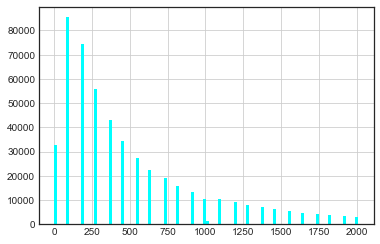

In [25]:
'''DOWNTIME: 
    Rows above 95 percentile were eliminated
    for downtime per Rob's instruction; landlords
    often have buildings off market for major rennovations.'''

# parameters: column
desc_stat_col('days_on_market')

# parameters: column, bins, lower_pct, upper_pct, color
make_hist('days_on_market', 100, 0, .95, 'aqua')

# parameters: column, lower, upper 
create_tag_column('days_on_market', 0, .95)


### Free Months

DESCRIPTIVE STATS WITHOUT MODIFICATIONS:

count   110560.00
mean         1.84
std          1.79
min          1.00
1%           1.00
5%           1.00
10%          1.00
25%          1.00
50%          2.00
75%          2.00
90%          3.00
95%          4.00
99%          7.00
max        185.00
Name: free_months, dtype: float64


HISTOGRAM WITH LOWER & UPPER BOUNDS REMOVED, lower: 0%, upper: 99.0%

NEW COLUMN CREATED WITH UPPER & LOWER BOUNDS: new_free_months
Data Frame shape: (989908, 45)


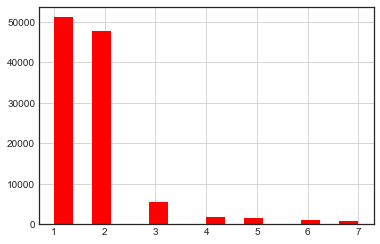

In [26]:
'''FREE MONTHS: 
    represented in # of free months...
    but could do as ratio...
    TODO: decide on abs value or relative pct/ratio'''

# parameters: column
desc_stat_col('free_months')

# parameters: column, bins, lower_pct, upper_pct, color
make_hist('free_months', 16, 0, .99, 'red')

# parameters: column, lower, upper 
create_tag_column('free_months', 0, .99)

### Tenant Improvement

DESCRIPTIVE STATS WITHOUT MODIFICATIONS:

count   3291.00
mean       3.10
std       27.87
min        0.00
1%         0.02
5%         0.07
10%        0.13
25%        0.27
50%        0.59
75%        1.18
90%        1.89
95%        2.45
99%       43.14
max      664.30
Name: ti_ratio, dtype: float64


HISTOGRAM WITH LOWER & UPPER BOUNDS REMOVED, lower: 0%, upper: 95.0%

NEW COLUMN CREATED WITH UPPER & LOWER BOUNDS: new_ti_ratio
Data Frame shape: (989908, 46)


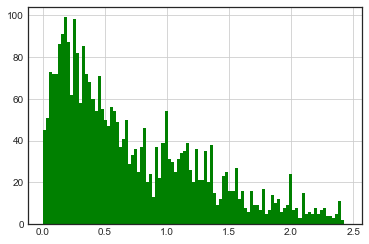

In [27]:
'''TENANT IMPROVEMENT:
    calculated as ratio of tenant_improvement_allowance_per_sqft
    and rent_actual, expressed in %'''

# parameters: column
desc_stat_col('ti_ratio')

# parameters: column, bins, lower_pct, upper_pct, color
make_hist('ti_ratio', 100, 0, .95, 'green')

# parameters: column, lower, upper 
create_tag_column('ti_ratio', 0, .95)

### Lease Term

DESCRIPTIVE STATS WITHOUT MODIFICATIONS:

count   989908.00
mean        49.11
std         40.32
min       -395.00
1%           0.00
5%          12.00
10%         12.00
25%         24.00
50%         36.00
75%         60.00
90%        108.00
95%        120.00
99%        192.00
max       1236.00
Name: lease_term_in_months, dtype: float64


HISTOGRAM WITH LOWER & UPPER BOUNDS REMOVED, lower: 1.0%, upper: 99.0%

NEW COLUMN CREATED WITH UPPER & LOWER BOUNDS: new_lease_term_in_months
Data Frame shape: (989908, 49)


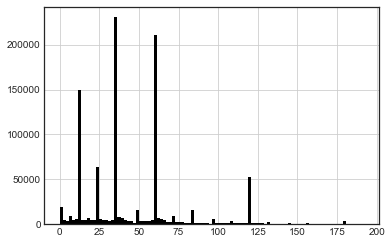

In [31]:
'''lease term in months'''

# parameters: column
desc_stat_col('lease_term_in_months')

# parameters: column, bins, lower_pct, upper_pct, color
make_hist('lease_term_in_months', 100, .01, .99, 'black')

# parameters: column, lower, upper 
create_tag_column('lease_term_in_months', .01, .99)

### Renewal

In [32]:
'''LEASE TERM:
    provided values (in months) are used'''

# #pie chart
# renew = dfm.renewal.to_numpy()
# plt.pie(renew)
# plt.show()

dfm['new_renewal'] = dfm.renewal
dfm.shape

(989908, 49)

### Rent Ratio

DESCRIPTIVE STATS WITHOUT MODIFICATIONS:

count   183085.00
mean         1.07
std         16.52
min          0.00
1%           0.37
5%           0.54
10%          0.63
25%          0.77
50%          0.91
75%          1.01
90%          1.13
95%          1.25
99%          1.79
max       3344.60
Name: rent_ratio, dtype: float64


HISTOGRAM WITH LOWER & UPPER BOUNDS REMOVED, lower: 1.0%, upper: 99.0%

NEW COLUMN CREATED WITH UPPER & LOWER BOUNDS: new_lease_term_in_months
Data Frame shape: (989908, 49)


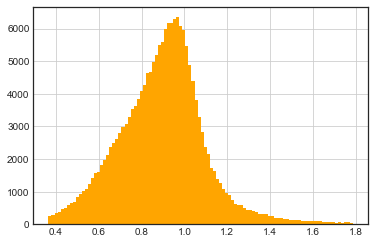

In [33]:
'''RENT RATIO:
    calculated from actual_rate / estimated_rent;
    there are observations close to zero
    and many times estimated_rent
    TODO: ask rob how to deal with these'''

# parameters: column
desc_stat_col('rent_ratio')

# parameters: column, bins, lower_pct, upper_pct, color
make_hist('rent_ratio', 100, .01, .99, 'orange')

# # observations where rent is btw 0 & 1% of estimated
# print(dfm.rent_ratio[(dfm.rent_ratio < 0.01) & (dfm.rent_ratio > 0.0)]:.3f)

# parameters: column, lower, upper 
create_tag_column('rent_ratio', .01, .99)

In [34]:
dfm.to_csv('top100_clean_tagged.csv')

In [36]:
print(os.getcwd())

C:\Users\clark


In [35]:
dfm.columns

Index(['leasedeal_id', 'property_id', 'renewal', 'sqft_min', 'sqft_max',
       'date_on_market', 'date_off_market', 'days_on_market', 'actual_vacancy',
       'from_date', 'to_date_', 'lease_sign_date', 'lease_expiration_date',
       'lease_term_in_months', 'rate_actual', 'estimated_rent',
       'service_type_id', 'property_type_id', 'location_occupancy_id', 'rba',
       'tenant_improvement_allowance_per_sqft', 'free_months',
       'construction_year', 'building_rating_id', 'research_market_name',
       'cbsaid', 'cbsa_cities', 'cbsa_states', 'submarket_name', 'zip',
       'currently_occupied_fl', 'year_on_market', 'year_off_market',
       'delete_rec', 'new_from_date', 'new_to_date', 'year_from', 'year_to',
       'years_occupied', 'actual_estimated_rent', 'property_count',
       'rent_ratio', 'ti_ratio', 'new_days_on_market', 'new_free_months',
       'new_ti_ratio', 'new_renewal', 'new_rent_ratio',
       'new_lease_term_in_months'],
      dtype='object')